# Defrost Cycle Analysis

## 1. Insight From Data: 
    From the data, we can observe that there are steady temperature in most of the time over a time interval. While there would also some peaks of increasing of temperature happen occastionally. Assumption can be made ,such that the steady temperature implies the working of the refrigeration devices. Meanwhile, the existence of peak of increasing temperature can be caused by the defrost cycle or other reasons, i.e overheating. 
    
## 2. Methodology

    From 1.Insight From Data, the prerequisite of finding the total number defrost cycle is to distinguish the cause of increase of temperature. To do that, my approach is to treating the time series data as a signal and denoise the signal to retrieve the frequency of defrost cycle. Then, we can calculate the number of defrost cycle with the frequency of it. 
    
    Fourrier Transform is used to do the denoise of signal. It is implemented in following steps:
    
    a. As Fourrier Transform required the input of a uniform time interval data, foward filling will be used to interpolate the missing data. Foward Filling, instead of mean, is used because foward filling can retain the trend of the signal which is important in this task.
    
    b. As aforementioned in 1. Insight From Data, steady temperature are observed most frequently. The highest amplitude of the frequency domain of the signal would be representing the steady temperature. The resulted graph is shown below (Sample Graph)
    
    c. Assuming defrost cycle is a regular event and happen more regular then other events causing the increase of temperature, i.e overheating of the refrigeration device. Based on this assumption, the second highest amplitude would be the frequency of the occurance of defrost. 
    
    d. The number of defrost in a day can be calculated by the formula : time in a day * frequency of defrost cycle, 
    i.e 144(number of 10 mins in a day) * frequency.


In [343]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [344]:
"""
A function using Fourier transform to identify the signal introduced by the defrost cycle to return the number of defrost occured
This function will also give a graph of refined temperature to time graph and defrost cycle graph

    param: str file_name 
            file name of the temperature dataframe
            
    return: int ans
            number of defrost cycle occured averagely in a day
    
"""
def forecast(file_name):
    raw_d = np.loadtxt(file_name,delimiter=",", dtype=str)
    t = []
    f = []
    
    # Set the timestamp of first col of data as 0 
    date_time_obj  = datetime.strptime(raw_d[1][0][:-6],'%Y-%m-%d %H:%M:%S')
    initial_timestamp = datetime.timestamp(date_time_obj)
    
    #store all timestamp to t[] 
    #store all temperature record corr to the timestamp in t[] to f[]
    for i in range(1,len(raw_d)):
        date_time_obj = datetime.strptime(raw_d[i][0][:-6],'%Y-%m-%d %H:%M:%S')
        timestamp = datetime.timestamp(date_time_obj) 
        
        # Resampling: foward filling to the missing data as the pattern(trend) of the data have to be preserved
        # Resample is needed as there might be missing data while fft only accept uniform data 
        if len(t)>0:
            
            temp_t = t[-1]
            while timestamp - temp_t >=1200:
                t.append(temp_t+600)
                temp_t = t[-1]
                #set the missing value temperature as the latest value (foward filling)
                f.append(float(raw_d[i][1]))
       
        #if the tracker misrecord data which has a too short interval, less than 20% of time interval, i.e <=2mins
        if len(t)>0 and len(f)>0 and timestamp - t[-1] <=120 and timestamp - t[-1] >0:
            f[-1] = (f[-1] + float(raw_d[i][1]))/2
        else:
            # Add the timestamp to t[] and corresponding temperature to f[]
            t.append(timestamp)
            f.append(float(raw_d[i][1]))

    
    #number of resampled sample
    n = len(f)
    
    # Compute the fft
    fhat = np.fft.fft(f,n)
    
    # Compute the Amplitude of the data in frequency domain
    A = fhat * np.conj(fhat) / n
    
    # Find the second highest amplitude of frequency
    idx = A >= sorted(A)[-2] 

    # Getting the average number of defrost cycle in a day
    ans = 0
    for i in range(len(idx)):
        if idx[i] and i!=0:
            ans = i*144/n
            
    # Removing noise of the original fft, only defrost cycle signal remained
    fhat = idx*fhat
    
    # Apply inverse fft to get the defrost cycle signal in time domain
    ffilt = np.fft.ifft(fhat) 

    # Plot Graph
    fig,axs = plt.subplots(1,2)
    plt.sca(axs[0])
    
    # Showing the graph of the resampled data with y-axis as temperature with corresponding x-axis of time(every 10mins)
    plt.title("Sample Graph")
    plt.ylabel("Temperature")
    plt.xlabel("Time (10 mins)")
    plt.plot([i for i in range(len(t))],f)
    plt.sca(axs[1])
    
    # Showing the graph of signal curve of the Defrost Cycle
    plt.title("Defrost Cycle Graph")
    plt.ylabel("Temperature")
    plt.xlabel("Time (10 mins)")
    plt.plot([i for i in range(144)], ffilt[:144])
    
    return ans

C:\Users\szeho\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


3.121182266009852

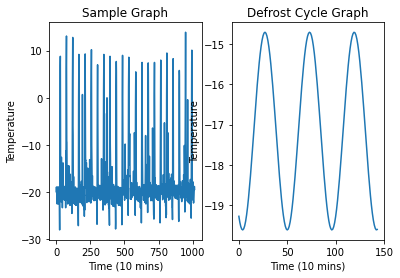

In [345]:

forecast("53175.csv")


The first graph shown the resampled data in temperature, time (every 10 mins) relationship. 

The second graph shown the defrost cycle in one day. The number of peak is the number of defrost in one day. 